## Download NOAA OISST satellite data and calculate a monthly mean for Iceland's waters. Using a 30 year climatology, 1982-2011. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# link from Don Murray, NOAA, from Pangeo_ESGF_search_and_load nb
oisst_full = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Aggregations/OISSThires/sst.mean.nc', chunks = {'time':100}) # this seems to be a good size
oisst_full # 1981-09-01 to 2020-07-06

,Array,Chunk
Bytes,59.40 GB,414.72 MB
Shape,"(14323, 720, 1440)","(100, 720, 1440)"
Count,145 Tasks,144 Chunks
Type,float32,numpy.ndarray


In [5]:
# subset appropriate time, region in the northeast Atlantic, and take monthly average
# From Vince: Actually, there is only partial data for 1981.  Go with 1982 to 2011.  That will give you an even 30-year climatology.


oisst_month_mn = oisst_full.sst.sel(time = slice ('1982', '2011'), lon=slice(-45, 15), lat=slice(50, 85)).groupby('time.month').mean('time')
oisst_month_mn.nbytes/1e6 # 49 MB for global file

49.7664

In [9]:
# convert to -180-180, crop to GINS region. lon is -45 to 15
oisst_180 = oisst_month_mn.assign_coords(lon=(((oisst_month_mn.lon + 180) % 360) - 180)).sortby('lon') 
oisst_180_crop = oisst_180.sel(lon = slice (-45, 15), lat = slice (50, 85))
oisst_180_crop.nbytes/1e6

1.6128

In [10]:
# write to netcdf
%time oisst_180_crop.to_netcdf('oisst_month_climatology_1982_2011.nc')

C:\Users\jmason\Miniconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [11]:
oisst_180_crop = xr.open_dataset('oisst_month_climatology_1982_2011.nc')
oisst_180_crop

<xarray.Dataset>
Dimensions:  (lat: 140, lon: 240, month: 12)
Coordinates:
  * lat      (lat) float32 50.125 50.375 50.625 50.875 ... 84.375 84.625 84.875
  * lon      (lon) float32 -44.875 -44.625 -44.375 ... 14.375 14.625 14.875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) float32 ...

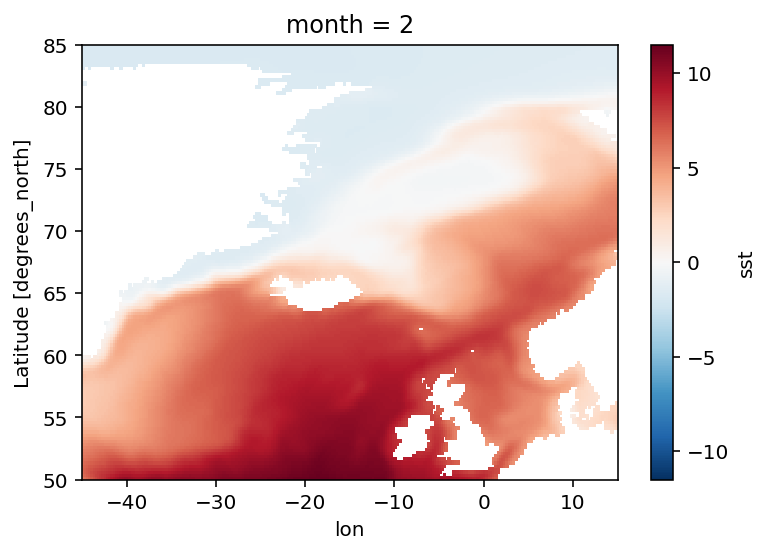

In [13]:
oisst_180_crop.sst.isel(month = 1).plot()